# Hierarchical regression

The following notes are based on 
* <cite data-cite="Gelman1999-yu">Gelman, Krantz, Lin, and Price (1999)</cite>
* [Chris Fonnesbeck - Stan Workshop 2016 - Multilevel Modeling](https://github.com/fonnesbeck/stan_workshop_2016/blob/master/notebooks/Multilevel%20Modeling.ipynb)
* <cite data-cite="Gelman2006-uo">Gelman and Hill (2006)</cite>

## Setup

### Install libraries

In [1]:
# %run -i 'plotting.py'

In [2]:
# !apt-get install -y fonts-lmodern
# !pip install -q arviz numpyro

### Add latin modern fonts

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager

In [4]:
## fonts_path = "/usr/share/texmf/fonts/opentype/public/lm/" #ubuntu
## fonts_path = "~/Library/Fonts/" # macos
fonts_path = "/usr/share/fonts/OTF/" # arch
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmsans10-regular.otf")
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmroman10-regular.otf")

### Set matplotlib to use latin modern fonts

In [5]:
from IPython.display import set_matplotlib_formats
# from IPython import matplotlib_inline
##%matplotlib inline
set_matplotlib_formats('svg') # use SVG backend to maintain vectorization
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')  # use SVG backend to maintain vectorization
plt.style.use('default') #reset default parameters
## https://stackoverflow.com/a/3900167/446907
plt.rcParams.update({'font.size': 16,
                     'font.family': ['sans-serif'],
                     'font.serif': ['Latin Modern Roman'] + plt.rcParams['font.serif'],
                     'font.sans-serif': ['Latin Modern Sans'] + plt.rcParams['font.sans-serif']})

<ipython-input-5-3ec050389011>:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg') # use SVG backend to maintain vectorization


## Generative models

### Example generative models

#### Univariate normal model

From a very simple perspective, generative modeling refers to the situation in which we develop a candidate probabilistic specification of the process from which our data are generated. Usually this will include the specification of prior distributions over all first-order parameters.

<div>
<center>    
<img src="https://www.bayespy.org/_images/tikz-57bc0c88a2974f4c1e2335fe9edb88ff2efdf970.png" style="background-color:white;" alt="Drawing" width="10%"/></center>
</div>

\begin{equation*}
\begin{split}
p(\mathbf{y}|\mu,\tau) &= \prod^{9}_{n=0} \mathcal{N}(y_n|\mu,\tau) \\
p(\mu) &= \mathcal{N}(\mu|0,10^{-6}) \\
p(\tau) &= \mathcal{G}(\tau|10^{-6},10^{-6})
\end{split}
\end{equation*}

This comes from the library [bayespy](https://github.com/bayespy/bayespy/blob/develop/doc/source/user_guide/quickstart.rst). The best description we are aware of regarding the syntax and semantics of graphical models via factor graph notation is in the [tikz-bayesnet](https://github.com/jluttine/tikz-bayesnet) library [technical report](https://github.com/jluttine/tikz-bayesnet/blob/master/dietz-techreport.pdf).

#### Multivariate normal models

<div>
<center>    
<img src="https://www.bayespy.org/_images/tikz-80a1db369be1f25b61ceacfff551dae2bdd331c3.png" style="background-color:white;" alt="Drawing" width="10%"/></center>
</div>

$$\mathbf{y}_{mn} \sim \mathcal{N}(\boldsymbol{\mu}, \mathbf{\Lambda}),\qquad m=0,\ldots,9, \quad n=0,\ldots,29.$$

<div>
<center>    
<img src="https://www.bayespy.org/_images/tikz-97236981a2be663d10ade1ad85caa727621615db.png" style="background-color:white;" alt="Drawing" width="20%"/></center>
</div>

$$\mathbf{y}_{mn} \sim \mathcal{N}(\boldsymbol{\mu}_m,
\mathbf{\Lambda}_n),\qquad m=0,\ldots,9, \quad n=0,\ldots,29.$$

Note that these are for illustrative purposes of the manner in which our data can share parameters and we have not yet defined priors over our parameters.

## Example of linear regression

### Setup

#### Load libraries

In [6]:
## %pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import numpy as np
## plt.style.use(['seaborn-talk'])
## plt.rcParams["figure.figsize"] = (10,8)

import arviz as az
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
print(numpyro.__version__)
print(jax.__version__)
print(az.__version__)

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

0.6.0
0.2.13
0.11.2


#### define colors

In [7]:
c_light ="#DCBCBC"
c_light_highlight ="#C79999"
c_mid ="#B97C7C"
c_mid_highlight ="#A25050"
c_dark ="#8F2727"
c_dark_highlight ="#7C0000"

### Import data

Import radon data

In [8]:
srrs2 = pd.read_csv('http://www.stat.columbia.edu/~gelman/arm/examples/radon/srrs2.dat')
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2.assign(fips=srrs2.stfips*1000 + srrs2.cntyfips)[srrs2.state=='MN']

In [9]:
print(type(srrs_mn))
srrs_mn.shape

<class 'pandas.core.frame.DataFrame'>


(919, 26)

In [10]:
srrs_mn.iloc[list(range(1,7))+list(range(800,806)),:]

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips
5081,5082,MN,MN,27,55748,5,1,0,4,Y,...,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001
5082,5083,MN,MN,27,55748,5,1,0,4,Y,...,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001
5083,5084,MN,MN,27,56469,5,1,0,4,Y,...,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001
5084,5085,MN,MN,27,55011,3,1,0,4,Y,...,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003
5085,5086,MN,MN,27,55014,3,1,0,4,Y,...,120287,121187,2.5,12.8,471.366223,0,0,3,ANOKA,27003
5086,5087,MN,MN,27,55014,3,1,0,4,Y,...,121887,122087,1.5,14.5,471.366223,0,0,3,ANOKA,27003
5880,5881,MN,MN,27,56378,2,1,1,3,Y,...,11688,11888,2.2,10.2,893.237430,0,0,145,STEARNS,27145
5881,5882,MN,MN,27,56379,2,1,0,4,Y,...,22388,22588,5.0,6.8,1071.318034,0,0,145,STEARNS,27145
5882,5883,MN,MN,27,55060,4,1,0,7,Y,...,121987,122287,7.3,4.0,990.411554,0,0,147,STEELE,27147
5883,5884,MN,MN,27,55060,4,1,0,4,Y,...,122387,122587,3.7,10.6,921.864905,1,0,147,STEELE,27147


In [11]:
sorted(srrs_mn)

['activity',
 'adjwt',
 'basement',
 'cntyfips',
 'county',
 'dupflag',
 'fips',
 'floor',
 'idnum',
 'pcterr',
 'region',
 'rep',
 'room',
 'startdt',
 'starttm',
 'state',
 'state2',
 'stfips',
 'stopdt',
 'stoptm',
 'stratum',
 'typebldg',
 'wave',
 'windoor',
 'zip',
 'zipflag']

In [12]:
list(srrs_mn.columns)

['idnum',
 'state',
 'state2',
 'stfips',
 'zip',
 'region',
 'typebldg',
 'floor',
 'room',
 'basement',
 'windoor',
 'rep',
 'stratum',
 'wave',
 'starttm',
 'stoptm',
 'startdt',
 'stopdt',
 'activity',
 'pcterr',
 'adjwt',
 'dupflag',
 'zipflag',
 'cntyfips',
 'county',
 'fips']

In [13]:
cty = pd.read_csv('http://www.stat.columbia.edu/~gelman/arm/examples/radon/cty.dat')
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

In [14]:
print(cty_mn.shape)
type(cty_mn)

(89, 8)


pandas.core.frame.DataFrame

In [15]:
cty_mn.iloc[list(range(1,7))+list(range(80,86)),:]

,stfips,ctfips,st,cty,lon,lat,Uppm,fips
1327,27,3,MN,ANOKA,-93.246,45.273,0.428565,27003
1328,27,5,MN,BECKER,-95.674,46.935,0.892741,27005
1329,27,7,MN,BELTRAMI,-94.937,47.974,0.552472,27007
1330,27,9,MN,BENTON,-93.998,45.699,0.866849,27009
1331,27,11,MN,BIGSTONE,-96.410,45.426,1.472640,27011
1332,27,13,MN,BLUEEARTH,-94.067,44.035,1.312080,27013
1406,27,157,MN,WABASHA,-92.230,44.284,1.161930,27157
1407,27,159,MN,WADENA,-94.969,46.586,0.510671,27159
1408,27,161,MN,WASECA,-93.587,44.022,1.236660,27161
1409,27,163,MN,WASHINGTON,-92.884,45.038,0.862876,27163


In [16]:
sorted(cty_mn)

['Uppm', 'ctfips', 'cty', 'fips', 'lat', 'lon', 'st', 'stfips']

### Transform data

Combine the home and county data.

In [17]:
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')

In [18]:
n = len(srrs_mn)

In [19]:
u = np.log(srrs_mn.Uppm)

In [20]:
list(srrs_mn.columns)

['idnum',
 'state',
 'state2',
 'stfips',
 'zip',
 'region',
 'typebldg',
 'floor',
 'room',
 'basement',
 'windoor',
 'rep',
 'stratum',
 'wave',
 'starttm',
 'stoptm',
 'startdt',
 'stopdt',
 'activity',
 'pcterr',
 'adjwt',
 'dupflag',
 'zipflag',
 'cntyfips',
 'county',
 'fips',
 'Uppm']

In [21]:
srrs_mn.apply(lambda x: pd.Series([x.min(), x.max()])).T.values.tolist()

[[5081, 5999],
 ['MN', 'MN'],
 ['MN', 'MN'],
 [27, 27],
 ['55007', '57006'],
 [1, 5],
 [0, 5],
 [0, 1],
 [0, 7],
 [' ', 'Y'],
 [' ', ' '],
 [' 1', ' 5'],
 [1, 5],
 ['  1', ' 50'],
 [0, 2337],
 [0, 2355],
 [10188, 123187],
 [10188, 123187],
 [0.0, 48.2],
 [0.0, 66.3],
 [348.042925, 2314.365189],
 [0, 2],
 [0, 1],
 [1, 173],
 ['AITKIN              ', 'YELLOW MEDICINE     '],
 [27001, 27173],
 [0.414025, 1.69558]]

In [22]:
pd.set_option("max_columns", None)
srrs_mn.describe().loc[['min','max']]
# pd.reset_option("max_columns")

,idnum,stfips,region,typebldg,floor,room,stratum,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,fips,Uppm
min,5081.0,27.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,10188.0,10188.0,0.0,0.0,348.042925,0.0,0.0,1.0,27001.0,0.414025
max,5999.0,27.0,5.0,5.0,1.0,7.0,5.0,2337.0,2355.0,123187.0,123187.0,48.2,66.3,2314.365189,2.0,1.0,173.0,27173.0,1.695580


In [23]:
sorted(srrs_mn)

['Uppm',
 'activity',
 'adjwt',
 'basement',
 'cntyfips',
 'county',
 'dupflag',
 'fips',
 'floor',
 'idnum',
 'pcterr',
 'region',
 'rep',
 'room',
 'startdt',
 'starttm',
 'state',
 'state2',
 'stfips',
 'stopdt',
 'stoptm',
 'stratum',
 'typebldg',
 'wave',
 'windoor',
 'zip',
 'zipflag']

In [24]:
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,windoor,rep,stratum,wave,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,,2,4,41,930,930,12088,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,,5,2,40,1615,1615,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,,3,2,42,1030,1515,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,,2,2,24,1410,1410,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,,3,2,40,600,600,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


In [25]:
srrs_mn.shape

(919, 27)

Create a list of the counties in Minnesota.

In [26]:
srrs_mn.county = srrs_mn.county.str.strip()
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)

In [27]:
print(mn_counties.shape)
mn_counties[0:5]

(85,)


array(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON'], dtype=object)

Extract relevant variables

In [28]:
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

Distribution of logarithmic radon levels across the entire state of Minnesota.

<AxesSubplot:>

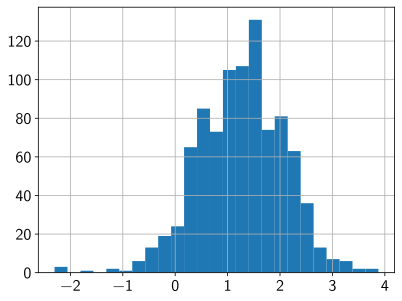

In [29]:
srrs_mn.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25)

### Complete pooling model

In [30]:
# import stan
from cmdstanpy import cmdstan_path, CmdStanModel
import os
import json

The complete pooling model considers houses within all counties to be the same. As such there is only one set of parameters required in this model.

$$ y_i = \alpha + \beta x_i + \epsilon_i $$

which may be written

$$ y_i \sim \mathcal{N} (\alpha + \beta x_i, \sigma) $$

We define the data for this model, which includes the number of samples ($N$), floor-within-house predictors ($x$), and the outcomes of log-radon measurments ($y$).

In [31]:
pooled_data = """
data{
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
"""

We define initializations for the parameters $\alpha$ and $\beta$.

In [32]:
pooled_parameters = """
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
"""

Model the log-radon measurements as samples from a normal distribution with mean a function of the floor of measurement.

In [33]:
pooled_model = """
model {
    y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""

In [34]:
pooled_model_file = open("pooled_model.stan", "w")
pooled_model_file.write(pooled_data + pooled_parameters + pooled_model)
pooled_model_file.close()

Recall the range of values for the floor predictor, $x$ is binary (ground vs other floor).

In [35]:
srrs_mn.floor.unique()
np.unique(floor_measure)

array([0, 1], dtype=int64)

In [36]:
pooled_data_dict = {'N': len(log_radon),
               'x': floor_measure.tolist(),
               'y': log_radon.tolist()}

In [37]:
pooled_data_file = open("pooled_model.data.json", "w")
json.dump(pooled_data_dict, pooled_data_file)
pooled_data_file.close()

In [38]:
pooled_stan = os.path.join('pooled_model.stan')

In [39]:
pooled_stan_model = CmdStanModel(stan_file=pooled_stan)

INFO:cmdstanpy:compiling stan program, exe file: /data-cameron/jovyan/projects/biostatistics-review/source/bayesian-biostatistics/pooled_model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /data-cameron/jovyan/projects/biostatistics-review/source/bayesian-biostatistics/pooled_model


In [40]:
pooled_stan_data = os.path.join('pooled_model.data.json')

In [41]:
pooled_stan_fit = pooled_stan_model.sample(chains=2, iter_sampling=1000 , data=pooled_stan_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


array([[<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

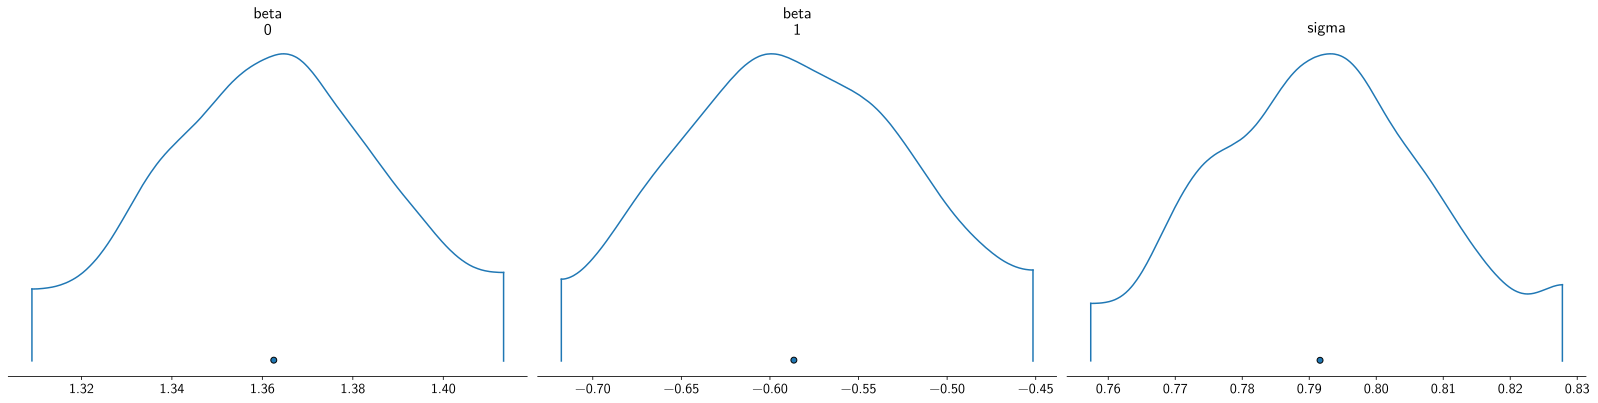

In [42]:
az.plot_density(pooled_stan_fit, var_names=["beta", "sigma"])

In [43]:
pooled_model_summary = pooled_stan_fit.summary(percentiles=[20,40,60,80])
pooled_model_summary

,Mean,MCSE,StdDev,20%,40%,60%,80%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,,
lp__,-240.00,0.04000,1.200,-240.00,-240.00,-240.00,-240.00,940.0,3800.0,1.0
beta[1],1.40,0.00082,0.028,1.30,1.40,1.40,1.40,1172.0,4725.0,1.0
beta[2],-0.59,0.00210,0.073,-0.65,-0.61,-0.57,-0.52,1183.0,4772.0,1.0
sigma,0.80,0.00000,0.000,0.80,0.80,0.80,0.80,1671.9,6741.3,1.0


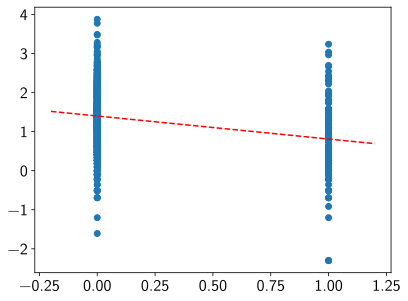

In [44]:
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, pooled_model_summary['Mean']['beta[2]']*xvals+pooled_model_summary['Mean']['beta[1]'], 'r--')

### No pooling model

The no pooling model considers houses in each county to be independent from one another. There are as many pairs of parameters as there are counties in this model.
$$ y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i $$
which may also be written

$$ y_i \sim \mathcal{N} (\alpha_{j[i]} + \beta x_i, \sigma) $$

In [45]:
unpooled_model = """data {
  int<lower=0> N; 
  int<lower=1,upper=85> county[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[85] a;
  real beta;
  real<lower=0,upper=100> sigma;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- beta * x[i] + a[county[i]];
}
model {
  y ~ normal(y_hat, sigma);
}"""

In [46]:
unpooled_model_file = open("unpooled_model.stan", "w")
unpooled_model_file.write(unpooled_model)
unpooled_model_file.close()

In [47]:
print(county.shape)
np.unique(county)

(919,)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84])

In [48]:
unpooled_data_dict = {'N': len(log_radon),
               'county': (county+1).tolist(), # Stan counts starting at 1
               'x': floor_measure.tolist(),
               'y': log_radon.tolist()}

In [49]:
unpooled_data_file = open("unpooled_model.data.json", "w")
json.dump(unpooled_data_dict, unpooled_data_file)
unpooled_data_file.close()

In [50]:
unpooled_stan = os.path.join('unpooled_model.stan')
unpooled_stan_model = CmdStanModel(stan_file=unpooled_stan)

INFO:cmdstanpy:compiling stan program, exe file: /data-cameron/jovyan/projects/biostatistics-review/source/bayesian-biostatistics/unpooled_model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /data-cameron/jovyan/projects/biostatistics-review/source/bayesian-biostatistics/unpooled_model


In [51]:
unpooled_stan_data = os.path.join('unpooled_model.data.json')
unpooled_stan_fit = unpooled_stan_model.sample(chains=2, iter_sampling=1000 , sig_figs=6, data=unpooled_stan_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


In [52]:
unpooled_stan_fit.save_csvfiles(dir='stan/')

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

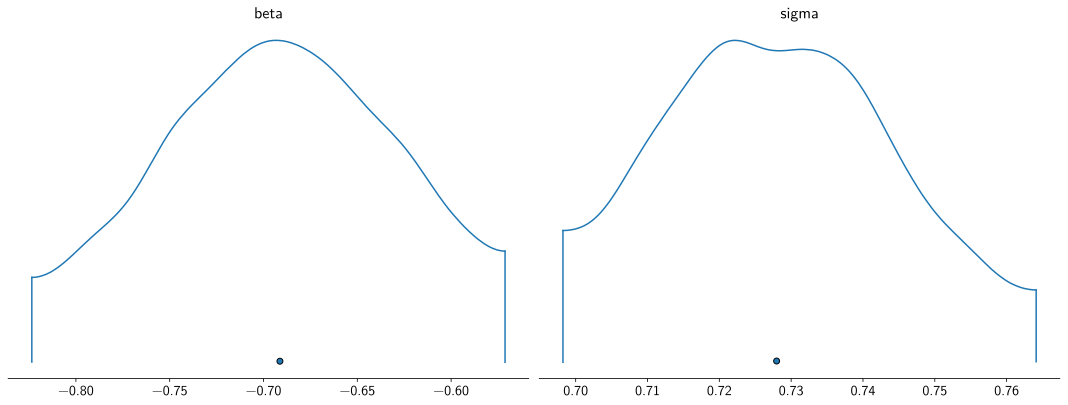

In [53]:
az.plot_density(unpooled_stan_fit, var_names=["beta", "sigma"])

In [54]:
unpooled_model_summary = unpooled_stan_fit.summary(percentiles=[20,40,60,80], sig_figs=4)
unpooled_model_summary

,Mean,MCSE,StdDev,20%,40%,60%,80%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,,
lp__,-167.0000,0.258800,6.9860,-172.5000,-168.5000,-164.9000,-161.100,728.9,644.4,0.9992
a[1],0.8795,0.007561,0.3594,0.5695,0.7898,0.9642,1.179,2259.0,1998.0,1.0000
a[2],0.9349,0.001812,0.1032,0.8481,0.9064,0.9595,1.023,3244.0,2868.0,0.9993
a[3],1.5500,0.010160,0.4369,1.1750,1.4310,1.6640,1.921,1848.0,1634.0,1.0010
a[4],1.5920,0.005735,0.2903,1.3490,1.5240,1.6590,1.832,2562.0,2266.0,0.9994
...,...,...,...,...,...,...,...,...,...,...
y_hat[915],1.6670,0.003603,0.1989,1.4970,1.6200,1.7140,1.837,3046.0,2693.0,0.9994
y_hat[916],1.6670,0.003603,0.1989,1.4970,1.6200,1.7140,1.837,3046.0,2693.0,0.9994
y_hat[917],1.6670,0.003603,0.1989,1.4970,1.6200,1.7140,1.837,3046.0,2693.0,0.9994


In [55]:
unpooled_stan_fit.diagnose();

INFO:cmdstanpy:Processing csv files: stan/unpooled_model-202106071502-1.csv, stan/unpooled_model-202106071502-2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


In [56]:
unpooled_model_intercepts = unpooled_model_summary.filter(regex='^a.*', axis=0)
unpooled_model_intercepts

,Mean,MCSE,StdDev,20%,40%,60%,80%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,,
a[1],0.8795,0.007561,0.3594,0.5695,0.7898,0.9642,1.179,2259.0,1998.0,1.0000
a[2],0.9349,0.001812,0.1032,0.8481,0.9064,0.9595,1.023,3244.0,2868.0,0.9993
a[3],1.5500,0.010160,0.4369,1.1750,1.4310,1.6640,1.921,1848.0,1634.0,1.0010
a[4],1.5920,0.005735,0.2903,1.3490,1.5240,1.6590,1.832,2562.0,2266.0,0.9994
a[5],1.4590,0.006017,0.3651,1.1570,1.3630,1.5530,1.753,3683.0,3256.0,0.9996
...,...,...,...,...,...,...,...,...,...,...
a[81],2.7070,0.008209,0.4108,2.3560,2.6080,2.8180,3.058,2504.0,2214.0,0.9991
a[82],2.2500,0.012660,0.7219,1.6390,2.0740,2.4330,2.840,3250.0,2873.0,0.9993
a[83],1.6540,0.003823,0.1910,1.5030,1.6100,1.7010,1.808,2496.0,2207.0,0.9997


In [57]:
unpooled_model_intercepts["County"] = [*range(1,len(unpooled_model_intercepts)+1)]
unpooled_model_intercepts["County Name"] = mn_counties
unpooled_model_intercepts_sorted = unpooled_model_intercepts.sort_values("Mean", axis=0)
unpooled_model_intercepts_sorted["Order"] = [*range(1,len(unpooled_model_intercepts)+1)]
unpooled_model_intercepts_sorted

<ipython-input-57-d2640068d70e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unpooled_model_intercepts["County"] = [*range(1,len(unpooled_model_intercepts)+1)]
<ipython-input-57-d2640068d70e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unpooled_model_intercepts["County Name"] = mn_counties


,Mean,MCSE,StdDev,20%,40%,60%,80%,N_Eff,N_Eff/s,R_hat,County,County Name,Order
name,,,,,,,,,,,,,
a[37],0.4855,0.004667,0.2397,0.2957,0.4297,0.5435,0.6845,2638.0,2333.0,0.9993,37,LAKE,1
a[16],0.7093,0.010260,0.5116,0.2784,0.5863,0.8421,1.1440,2487.0,2199.0,1.0000,16,COOK,2
a[79],0.7109,0.007421,0.3629,0.4029,0.6266,0.8036,1.0220,2391.0,2114.0,0.9999,79,WASECA,3
a[22],0.7767,0.006211,0.2968,0.5197,0.6932,0.8562,1.0280,2283.0,2019.0,0.9993,22,FARIBAULT,4
a[57],0.8150,0.006325,0.3053,0.5546,0.7390,0.8895,1.0690,2329.0,2060.0,1.0000,57,PINE,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
a[82],2.2500,0.012660,0.7219,1.6390,2.0740,2.4330,2.8400,3250.0,2873.0,0.9993,82,WILKIN,81
a[40],2.3220,0.006901,0.3677,2.0150,2.2320,2.4250,2.6350,2839.0,2510.0,0.9998,40,LINCOLN,82
a[50],2.4900,0.013620,0.7247,1.9020,2.3020,2.6470,3.1040,2831.0,2503.0,1.0010,50,MURRAY,83


Text(0, 0.5, 'Radon estimate $(\\log_{10})$')

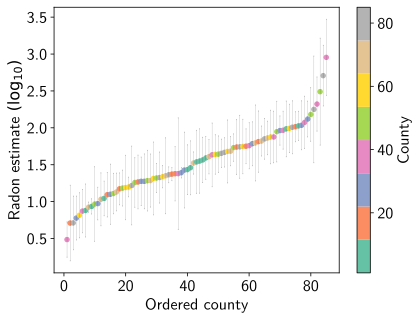

In [58]:
ax = unpooled_model_intercepts_sorted.plot.scatter(x="Order", y="Mean", c="County", 
                                                   colormap=plt.cm.get_cmap('Set2', 8))
ax.errorbar(unpooled_model_intercepts_sorted["Order"], unpooled_model_intercepts_sorted["Mean"], 
            yerr=unpooled_model_intercepts_sorted["StdDev"], xerr=None, color="black", alpha=0.5, capsize=0.2, linewidth=0.2, ls='none')
ax.set_xlabel("Ordered county")
ax.set_ylabel("Radon estimate $(\log_{10})$")

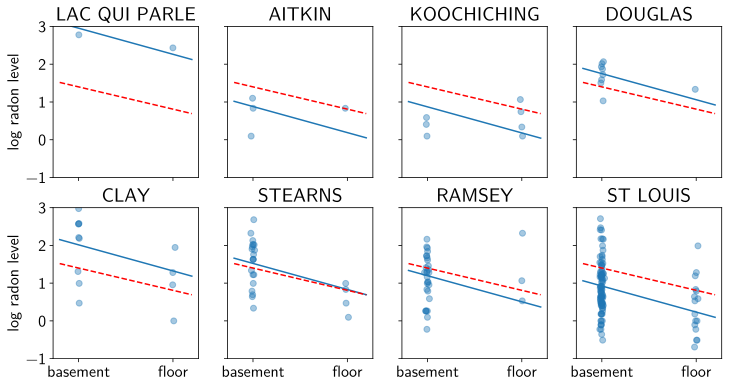

In [59]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_model_summary["Mean"]["beta"]
m0 = pooled_model_summary['Mean']['beta[2]']
b0 = pooled_model_summary['Mean']['beta[1]']

for i,c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_model_intercepts[unpooled_model_intercepts["County Name"]==c]["Mean"].values[0]
    
    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%4:
        axes[i].set_ylabel('log radon level')